# Wednesday, December 3rd, 2025

## Recap: 
We've been discussing implementing Conway's [Game of Life](https://conwaylife.com/wiki/Conway%27s_Game_of_Life) in Python. First, let's recall some of the code that we have developed so far. To start, we import NumPy and PyPlot..

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We defined the `get_padded_cells` function (which was based on the analagous function from our Image Denoising project), which placed rows of non-living cells above and below and columns of non-living cells to the left and right of our `cells` array. This function returns this new `padded_cells` array.

In [2]:
def get_padded_cells(cells, pad=1):
    num_rows, num_cols = cells.shape
    padded_cells = np.zeros((num_rows + 2*pad, num_cols + 2*pad), dtype=int)
    padded_cells[pad:-pad, pad:-pad] = cells
    return padded_cells

Last time, we re-wrote our `count_live_neighbors` function so that it now takes in an array `cells` (giving the current configuration of the game) and returns an array `live_neighbors_array` where the `[i,j]`th element counts the number of live neighbors of `cells[i,j]`.

In [3]:
def count_live_neighbors(cells):
    padded_cells = get_padded_cells(cells)
    
    cells_shifts = []               # Initialize an empty list to contain each shifted version of the `cells` array
    
    num_rows, num_cols = padded_cells.shape
    for i_shift in [-1,0,1]:                    # For vertical shifts right, centered, and left
        for j_shift in [-1,0,1]:                # For horizontal shifts up, centered, and down
            if i_shift == 0 and j_shift == 0:   # If we are considering the unshifted `cells` array...
                continue                        # ...skip to the next shift
            # Take a slice of the padded array that is shifted left/right by i_shift and up/down by j_shift
            cells_shift = padded_cells[1 + i_shift:num_rows-1 + i_shift, 1 + j_shift:num_cols-1 + j_shift]
            cells_shifts.append(cells_shift)
    
    cells_shifts = np.array(cells_shifts)   # Convert to an array for ease of slicing

    live_neighbors_array = np.sum(cells_shifts,axis=0)

    return live_neighbors_array

We also re-wrote our `update_cells` function to take advantage of this new `count_live_neighbors` function. We also took advantage of Boolean masking to apply the rules of the Game of Life without needing to use any (or very few) Python `for` loops.

In [20]:
def update_cells(cells):
    live_neighbors_array = count_live_neighbors(cells)

    live_cells = (cells == 1)                              # Identify living cells
    dead_cells = (cells == 0)                              # Identify dead cells
    two_live_neighbors = (live_neighbors_array == 2)       # Identify cells with exactly two live neighbors
    three_live_neighbors = (live_neighbors_array == 3)     # Identify cells with exactly three live neighbors
    
    stay_alive_mask = live_cells * (two_live_neighbors + three_live_neighbors)   # Identify living cells with exactly two or three live neighbors
    become_alive_mask = dead_cells * three_live_neighbors                        # Identify dead cells with exactly three live neighbors

    updated_cells = np.zeros(cells.shape, dtype=int)  # Initialize all updated cell states to be 0 (dead)
    updated_cells[stay_alive_mask] = 1                # Set states to 1 for all cells that were alive and are to remain alive
    updated_cells[become_alive_mask] = 1              # Set states to 1 for all cells that were dead but are to become alive
                                                      # From the rules of life, all other cell states should be 0 (as was intially set)

    return updated_cells

We saw that these updated functions gave tremendous speed improvements (~$80\times$ faster on my machine when simulating a `500` $\times$ `500` grid of cells).

Also, recall the `random_starting_state` and `simulate_game_of_life` functions that we used to setup and run simulations.

In [21]:
def random_starting_state(n=50, percent_live_cells=.1):
    cells = np.zeros((n,n), dtype=int)
    live_cell_mask = np.random.random((n,n)) < percent_live_cells
    cells[live_cell_mask] = 1
    return cells

In [22]:
def simulate_game_of_life(cells, T):
    n,m = cells.shape
    cells_history = np.zeros((n, m, T+1), dtype=int)
    cells_history[:,:,0] = cells
    
    for t in range(T):
        cells_history[:,:,t+1] = update_cells(cells_history[:,:,t])

    return cells_history

## Analyzing the Game of Life

Let's return to some of the questions we previously wanted to explore about the Game of Life.

**Exercise:** For a given choice of parameters `n` (the square grid size), `percent_live_cells` (the portion of randomly selected cells that will be initially set to living), and `T` (number of time steps to simulate), simulate the Game of Life many times. Plot the number of live cells as a function of time along with the average the number of live cells between these numerous simulations in a single plot.

Before running the simulations, we can create an array (initially full of zeros) with shape `(number_of_simulations, n, n, T+1)` that will store the results from each simulation. The first dimension separates each particular simulation, the second and third dimensions are the spatial dimensions of the `cells` grid, and the fourth dimension is the temporal dimension.

In [23]:
number_of_simulations = 10
n = 100
T = 100
percent_live_cells = .3

simulation_histories = np.zeros((number_of_simulations, n, n, T+1))
for i in range(number_of_simulations):
    cells = random_starting_state(n, percent_live_cells)
    simulation_histories[i,:,:,:] = simulate_game_of_life(cells, T)

Now that we've run several simulations, let's pick out the history of live cells for each simulation. That is, for each simulation and each time step, we want to add together all of the entries of the configuration of cells. In other words, we want to apply `np.sum` to the `simulation_histories` array, but only compute the sum through `axis=(1,2)` (the two spatial dimensions).

In [24]:
number_of_live_cells_histories = np.sum(simulation_histories, axis=(1,2))

Finally, we can plot each of these histories of live cells along with the average computed across each simulation. The average across each simulation can be computed using `np.mean` with the optional argument `axis=0` (the simulation dimension).

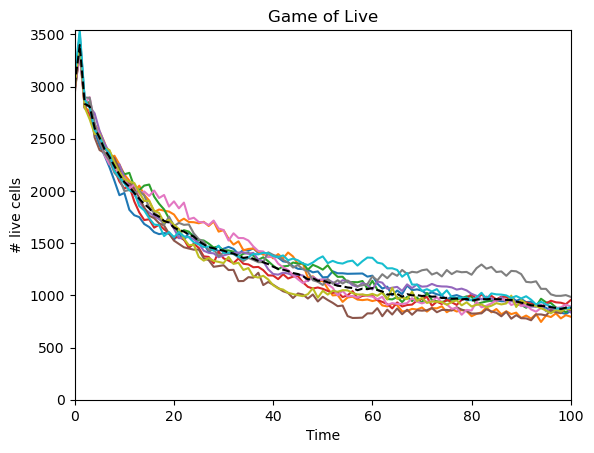

In [25]:
t_history = np.arange(T+1)
for number_of_live_cells_history in number_of_live_cells_histories:
    plt.plot(t_history, number_of_live_cells_history)

number_of_live_cells_histories_average = np.mean(number_of_live_cells_histories, axis=0)
plt.plot(t_history, number_of_live_cells_histories_average, 'k--')

plt.title('Game of Live')
plt.xlabel('Time')
plt.ylabel('# live cells')

plt.xlim(0,T)
plt.ylim((0, np.max(number_of_live_cells_histories)))
plt.show()

**Exercise:** For a given choice of parameters `n` and `T`, simulate the Game of Life with several different choices of `percent_live_cells` used to generate the random initial configuration. Plot the number of live cells as a function of time for these numerous simulations in a single plot.

In [26]:
for letter in ['a','b','c', 'd']:
    print(letter)

a
b
c
d


In [27]:
for i,letter in enumerate(['a','b','c', 'd']):
    print(i, letter)

0 a
1 b
2 c
3 d


In [39]:
number_of_simulations = 5
n = 100
T = 400

percent_live_cells_array = np.linspace(.1, .9, number_of_simulations)

simulation_histories = np.zeros((number_of_simulations, n, n, T+1))
for i, percent_live_cells, in enumerate(percent_live_cells_array):
    cells = random_starting_state(n, percent_live_cells)
    simulation_histories[i,:,:,:] = simulate_game_of_life(cells, T)

number_of_live_cells_histories = np.sum(simulation_histories, axis=(1,2))

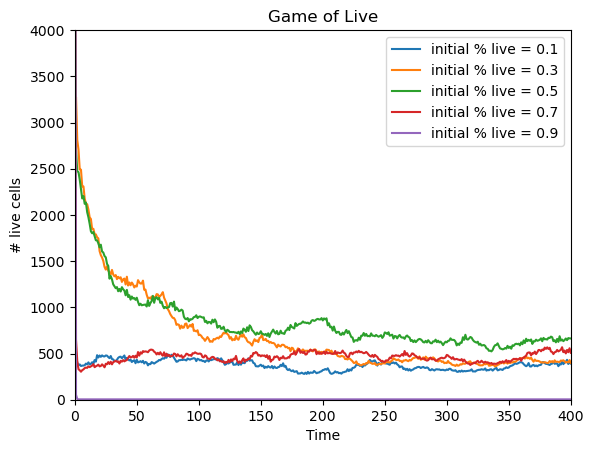

In [40]:
t_history = np.arange(T+1)
for number_of_live_cells_history, percent_live_cells in zip(number_of_live_cells_histories, percent_live_cells_array):
    plt.plot(t_history, number_of_live_cells_history, label='initial % live = {:0.1f}'.format(percent_live_cells))

plt.legend()

plt.title('Game of Live')
plt.xlabel('Time')
plt.ylabel('# live cells')

plt.xlim(0,T)
#plt.ylim((0, np.max(number_of_live_cells_histories)))
plt.ylim((0, 4000))
plt.show()

**Exercise:** For a given choice of parameters `percent_live_cells` and `T`, simulate the Game of Life with several different choices of square grid size `n`. Instead of plotting the number of live cells as a function of time, normalize this count by the size of the grid (e.g. by dividing by `n**2`). Plot this normalized count for each of the simulations in a single plot.

In [64]:
n_list = [50, 100, 200, 400, 800]
number_of_simulations = len(n_list)

T = 200
percent_live_cells = .6

simulation_histories = []
for n in n_list:
    cells = random_starting_state(n, percent_live_cells)
    simulation_histories.append(simulate_game_of_life(cells, T))

number_of_live_cells_histories = [np.sum(simulation_history, axis=(0,1)) for simulation_history in simulation_histories]

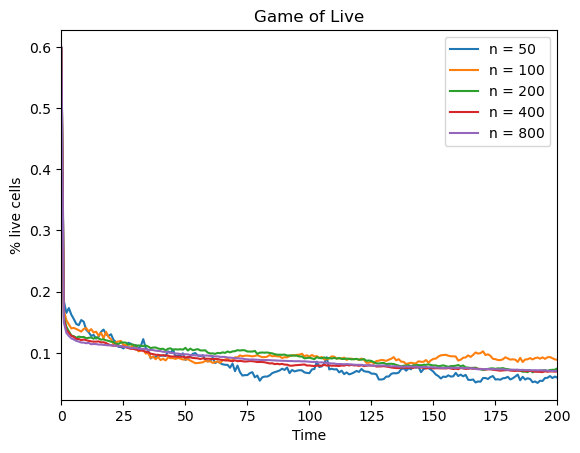

In [65]:
t_history = np.arange(T+1)
for number_of_live_cells_history, n in zip(number_of_live_cells_histories, n_list):
    plt.plot(t_history, number_of_live_cells_history / n**2, label='n = {}'.format(n))

plt.legend()

plt.title('Game of Live')
plt.xlabel('Time')
plt.ylabel('% live cells')

plt.xlim(0,T)
plt.show()

**Exercise:** For a given choice of parameter `T`, simulate the Game of Life with several combinations of choices for `n` and `percent_live_cells`. For each simulation, calculate the average number of live cells from the last `10` times steps (choose `T > 10` at least). Create an array to store this data and use `plt.imshow` to visualize this array.